## Traffic

Epoch 1, Train Loss: 0.0132, Test Loss: 0.0108
Epoch 2, Train Loss: 0.0086, Test Loss: 0.0066
Epoch 3, Train Loss: 0.0051, Test Loss: 0.0062
Epoch 4, Train Loss: 0.0045, Test Loss: 0.0051
Epoch 5, Train Loss: 0.0045, Test Loss: 0.0023
Epoch 6, Train Loss: 0.0028, Test Loss: 0.0020
Epoch 7, Train Loss: 0.0021, Test Loss: 0.0018
Epoch 8, Train Loss: 0.0023, Test Loss: 0.0020
Epoch 9, Train Loss: 0.0021, Test Loss: 0.0012
Epoch 10, Train Loss: 0.0018, Test Loss: 0.0015
Evaluation MAE: 0.0287
Evaluation MSE: 0.0015


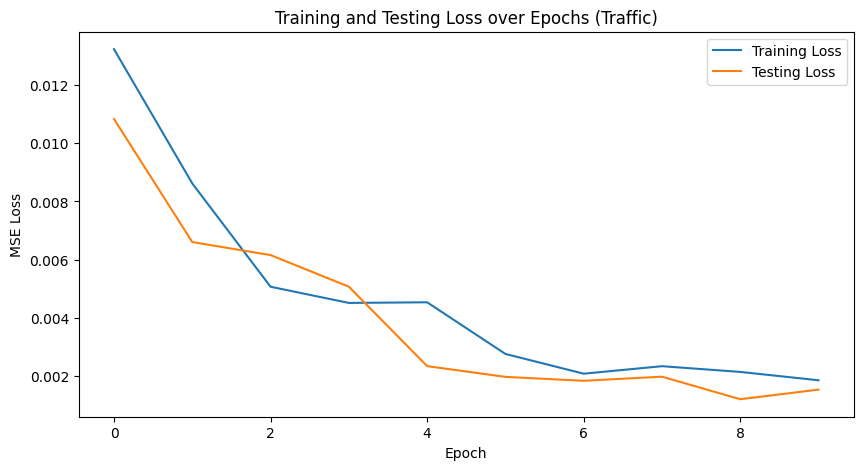

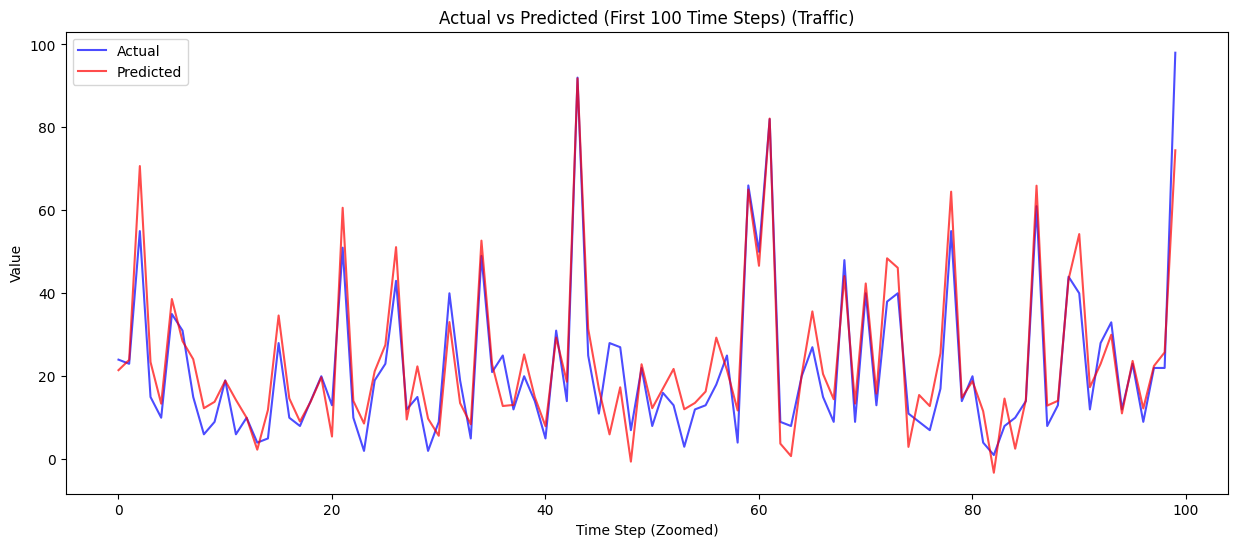

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random

# Set random seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False    # Disable cuDNN auto-tuner for deterministic results

# Seed the random number generators
set_seed(42)

# Adaptive Binarization Function
class AdaptiveBinarize(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, threshold=0.0):
        ctx.save_for_backward(input)
        return (input >= threshold).float() * 2 - 1

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input.abs() > 1] = 0  # Straight-Through Estimator
        return grad_input, None

# Partial Binarized Linear Layer
class PartialBinarizedLinear(nn.Module):
    def __init__(self, in_features, out_features, binarize=True):
        super(PartialBinarizedLinear, self).__init__()
        self.binarize = binarize
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        if self.binarize:
            binarized_weights = AdaptiveBinarize.apply(self.linear.weight)
            return nn.functional.linear(x, binarized_weights, self.linear.bias)
        else:
            return self.linear(x)

# Adaptive Partial Binarized LSTM
class AdaptivePartialBinarizedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, binarize_gates=True):
        super(AdaptivePartialBinarizedLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.binarize_gates = binarize_gates

        # Input-to-Hidden Transformation
        self.i2h = nn.Linear(input_size, hidden_size * 4)
        # Hidden-to-Hidden Transformation
        self.h2h = PartialBinarizedLinear(hidden_size, hidden_size * 4, binarize=binarize_gates)
        # Output Layer
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        h, c = hidden
        batch_size, seq_len, _ = x.size()

        for t in range(seq_len):
            xt = x[:, t, :]
            gates = self.i2h(xt) + self.h2h(h)

            # Split gates
            input_gate, forget_gate, output_gate, candidate = gates.chunk(4, dim=1)

            # Apply activations
            input_gate = torch.sigmoid(AdaptiveBinarize.apply(input_gate) if self.binarize_gates else input_gate)
            forget_gate = torch.sigmoid(AdaptiveBinarize.apply(forget_gate) if self.binarize_gates else forget_gate)
            output_gate = torch.sigmoid(AdaptiveBinarize.apply(output_gate) if self.binarize_gates else output_gate)
            candidate = torch.tanh(candidate)

            # Compute new states
            new_c = forget_gate * c + input_gate * candidate
            new_h = output_gate * torch.tanh(new_c)

            c, h = new_c, new_h

        out = self.output(h)
        return out, (h, c)

    def init_hidden(self, batch_size):
        return (torch.zeros(batch_size, self.hidden_size),
                torch.zeros(batch_size, self.hidden_size))

# Load and Preprocess the Dataset
def load_data(dataset_type='weather'):
    if dataset_type == 'weather':
        # Load weather dataset (replace with the actual file path)
        df = pd.read_csv("/content/weatherHistory.csv", parse_dates=['Formatted Date'], index_col='Formatted Date')
        data = df['Temperature (C)'].values.reshape(-1, 1)
        seq_len = 24  # Use 24 time steps for prediction (representing 1 day of hourly data)
    elif dataset_type == 'traffic':
        # Load traffic dataset (replace with the actual file path)
        df = pd.read_csv("/content/traffic.csv", parse_dates=['DateTime'], index_col='DateTime')
        data = df['Vehicles'].values.reshape(-1, 1)
        seq_len = 96  # Use 96 time steps for prediction (representing 1 day of 15-minute intervals)

    # Normalize the dataset
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    # Prepare sequences
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])

    return np.array(X), np.array(y), scaler

# Dataset Preparation
dataset_type = 'traffic'   # Change this to 'weather' to use the weather dataset
X, y, scaler = load_data(dataset_type)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_eval, y_test, y_eval = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

X_train, X_test, X_eval = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32), torch.tensor(X_eval, dtype=torch.float32)
y_train, y_test, y_eval = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32), torch.tensor(y_eval, dtype=torch.float32)

# DataLoader for mini-batches
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
eval_dataset = TensorDataset(X_eval, y_eval)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle=False)

# Device setup for GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Initialization
input_size = X.shape[2]
hidden_size = 16
output_size = y.shape[1]
model = AdaptivePartialBinarizedLSTM(input_size=input_size, hidden_size=hidden_size, output_size=output_size, binarize_gates=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training Loop
num_epochs = 10
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        hidden = model.init_hidden(X_batch.size(0))
        hidden = (hidden[0].to(device), hidden[1].to(device))  # Move hidden state to GPU
        output, hidden = model(X_batch, hidden)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))

    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            hidden = model.init_hidden(X_batch.size(0))
            hidden = (hidden[0].to(device), hidden[1].to(device))  # Move hidden state to GPU
            output, hidden = model(X_batch, hidden)
            loss = criterion(output, y_batch)
            epoch_test_loss += loss.item()

    test_losses.append(epoch_test_loss / len(test_loader))

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

# Evaluate the model on the evaluation dataset
model.eval()
y_eval_pred = []
y_eval_true = []
with torch.no_grad():
    for X_batch, y_batch in eval_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        hidden = model.init_hidden(X_batch.size(0))
        hidden = (hidden[0].to(device), hidden[1].to(device))  # Move hidden state to GPU
        output, hidden = model(X_batch, hidden)
        y_eval_pred.append(output)
        y_eval_true.append(y_batch)

y_eval_pred = torch.cat(y_eval_pred, dim=0)
y_eval_true = torch.cat(y_eval_true, dim=0)

# Calculate MAE and MSE for the evaluation set
mae = mean_absolute_error(y_eval_true.cpu().numpy(), y_eval_pred.cpu().numpy())
mse = mean_squared_error(y_eval_true.cpu().numpy(), y_eval_pred.cpu().numpy())

print(f"Evaluation MAE: {mae:.4f}")
print(f"Evaluation MSE: {mse:.4f}")

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title(f"Training and Testing Loss over Epochs ({dataset_type.capitalize()})")
plt.legend()
plt.show()

# Inverse transform for actual and predicted values
y_eval_true_unscaled = scaler.inverse_transform(y_eval_true.cpu().numpy())
y_eval_pred_unscaled = scaler.inverse_transform(y_eval_pred.cpu().numpy())

# Zoom in on the first 500 time steps
plt.figure(figsize=(15, 6))
plt.plot(y_eval_true_unscaled[:100], label='Actual', color='blue', alpha=0.7)
plt.plot(y_eval_pred_unscaled[:100], label='Predicted', color='red', alpha=0.7)
plt.xlabel("Time Step (Zoomed)")
plt.ylabel("Value")
plt.title(f"Actual vs Predicted (First 100 Time Steps) ({dataset_type.capitalize()})")
plt.legend()
plt.show()

## Weather

Epoch 1, Train Loss: 0.0139, Test Loss: 0.0082
Epoch 2, Train Loss: 0.0050, Test Loss: 0.0040
Epoch 3, Train Loss: 0.0035, Test Loss: 0.0028
Epoch 4, Train Loss: 0.0024, Test Loss: 0.0021
Epoch 5, Train Loss: 0.0019, Test Loss: 0.0016
Epoch 6, Train Loss: 0.0015, Test Loss: 0.0013
Epoch 7, Train Loss: 0.0014, Test Loss: 0.0021
Epoch 8, Train Loss: 0.0012, Test Loss: 0.0009
Epoch 9, Train Loss: 0.0010, Test Loss: 0.0010
Epoch 10, Train Loss: 0.0009, Test Loss: 0.0010
Evaluation MAE: 0.0238
Evaluation MSE: 0.0010


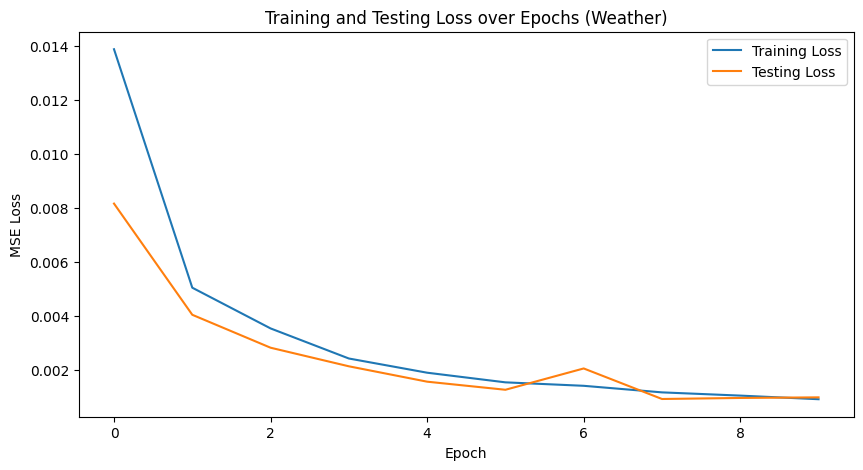

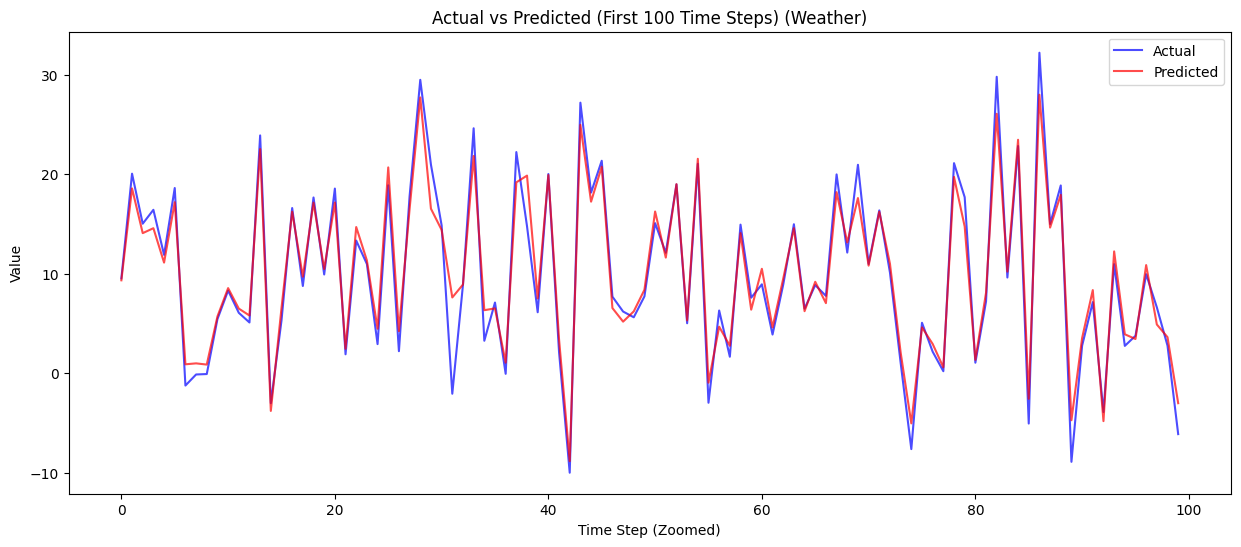

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random

# Set random seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False    # Disable cuDNN auto-tuner for deterministic results

# Seed the random number generators
set_seed(42)

# Adaptive Binarization Function
class AdaptiveBinarize(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, threshold=0.0):
        ctx.save_for_backward(input)
        return (input >= threshold).float() * 2 - 1

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input.abs() > 1] = 0  # Straight-Through Estimator
        return grad_input, None

# Partial Binarized Linear Layer
class PartialBinarizedLinear(nn.Module):
    def __init__(self, in_features, out_features, binarize=True):
        super(PartialBinarizedLinear, self).__init__()
        self.binarize = binarize
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        if self.binarize:
            binarized_weights = AdaptiveBinarize.apply(self.linear.weight)
            return nn.functional.linear(x, binarized_weights, self.linear.bias)
        else:
            return self.linear(x)

# Adaptive Partial Binarized LSTM
class AdaptivePartialBinarizedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, binarize_gates=True):
        super(AdaptivePartialBinarizedLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.binarize_gates = binarize_gates

        # Input-to-Hidden Transformation
        self.i2h = nn.Linear(input_size, hidden_size * 4)
        # Hidden-to-Hidden Transformation
        self.h2h = PartialBinarizedLinear(hidden_size, hidden_size * 4, binarize=binarize_gates)
        # Output Layer
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        h, c = hidden
        batch_size, seq_len, _ = x.size()

        for t in range(seq_len):
            xt = x[:, t, :]
            gates = self.i2h(xt) + self.h2h(h)

            # Split gates
            input_gate, forget_gate, output_gate, candidate = gates.chunk(4, dim=1)

            # Apply activations
            input_gate = torch.sigmoid(AdaptiveBinarize.apply(input_gate) if self.binarize_gates else input_gate)
            forget_gate = torch.sigmoid(AdaptiveBinarize.apply(forget_gate) if self.binarize_gates else forget_gate)
            output_gate = torch.sigmoid(AdaptiveBinarize.apply(output_gate) if self.binarize_gates else output_gate)
            candidate = torch.tanh(candidate)

            # Compute new states
            new_c = forget_gate * c + input_gate * candidate
            new_h = output_gate * torch.tanh(new_c)

            c, h = new_c, new_h

        out = self.output(h)
        return out, (h, c)

    def init_hidden(self, batch_size):
        return (torch.zeros(batch_size, self.hidden_size),
                torch.zeros(batch_size, self.hidden_size))

# Load and Preprocess the Dataset
def load_data(dataset_type='weather'):
    if dataset_type == 'weather':
        # Load weather dataset (replace with the actual file path)
        df = pd.read_csv("/content/weatherHistory.csv", parse_dates=['Formatted Date'], index_col='Formatted Date')
        data = df['Temperature (C)'].values.reshape(-1, 1)
        seq_len = 24  # Use 24 time steps for prediction (representing 1 day of hourly data)
    elif dataset_type == 'traffic':
        # Load traffic dataset (replace with the actual file path)
        df = pd.read_csv("/content/traffic.csv", parse_dates=['DateTime'], index_col='DateTime')
        data = df['Vehicles'].values.reshape(-1, 1)
        seq_len = 96  # Use 96 time steps for prediction (representing 1 day of 15-minute intervals)

    # Normalize the dataset
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    # Prepare sequences
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])

    return np.array(X), np.array(y), scaler

# Dataset Preparation
dataset_type = 'weather'   # Change this to 'traffic' to use the traffic dataset
X, y, scaler = load_data(dataset_type)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_eval, y_test, y_eval = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

X_train, X_test, X_eval = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32), torch.tensor(X_eval, dtype=torch.float32)
y_train, y_test, y_eval = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32), torch.tensor(y_eval, dtype=torch.float32)

# DataLoader for mini-batches
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
eval_dataset = TensorDataset(X_eval, y_eval)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle=False)

# Device setup for GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Initialization
input_size = X.shape[2]
hidden_size = 16
output_size = y.shape[1]
model = AdaptivePartialBinarizedLSTM(input_size=input_size, hidden_size=hidden_size, output_size=output_size, binarize_gates=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training Loop
num_epochs = 10
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        hidden = model.init_hidden(X_batch.size(0))
        hidden = (hidden[0].to(device), hidden[1].to(device))  # Move hidden state to GPU
        output, hidden = model(X_batch, hidden)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))

    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            hidden = model.init_hidden(X_batch.size(0))
            hidden = (hidden[0].to(device), hidden[1].to(device))  # Move hidden state to GPU
            output, hidden = model(X_batch, hidden)
            loss = criterion(output, y_batch)
            epoch_test_loss += loss.item()

    test_losses.append(epoch_test_loss / len(test_loader))

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

# Evaluate the model on the evaluation dataset
model.eval()
y_eval_pred = []
y_eval_true = []
with torch.no_grad():
    for X_batch, y_batch in eval_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        hidden = model.init_hidden(X_batch.size(0))
        hidden = (hidden[0].to(device), hidden[1].to(device))  # Move hidden state to GPU
        output, hidden = model(X_batch, hidden)
        y_eval_pred.append(output)
        y_eval_true.append(y_batch)

y_eval_pred = torch.cat(y_eval_pred, dim=0)
y_eval_true = torch.cat(y_eval_true, dim=0)

# Calculate MAE and MSE for the evaluation set
mae = mean_absolute_error(y_eval_true.cpu().numpy(), y_eval_pred.cpu().numpy())
mse = mean_squared_error(y_eval_true.cpu().numpy(), y_eval_pred.cpu().numpy())

print(f"Evaluation MAE: {mae:.4f}")
print(f"Evaluation MSE: {mse:.4f}")

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title(f"Training and Testing Loss over Epochs ({dataset_type.capitalize()})")
plt.legend()
plt.show()

# Inverse transform for actual and predicted values
y_eval_true_unscaled = scaler.inverse_transform(y_eval_true.cpu().numpy())
y_eval_pred_unscaled = scaler.inverse_transform(y_eval_pred.cpu().numpy())

# Zoom in on the first 500 time steps
plt.figure(figsize=(15, 6))
plt.plot(y_eval_true_unscaled[:100], label='Actual', color='blue', alpha=0.7)
plt.plot(y_eval_pred_unscaled[:100], label='Predicted', color='red', alpha=0.7)
plt.xlabel("Time Step (Zoomed)")
plt.ylabel("Value")
plt.title(f"Actual vs Predicted (First 100 Time Steps) ({dataset_type.capitalize()})")
plt.legend()
plt.show()